# Mise en place de l'environnement

In [57]:
# On importe les packages nécesaires au machine learning
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score, roc_auc_score, plot_roc_curve

In [58]:
# On met en place Mlflow pour suivre les performances de nos modèles
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse

# On crée une nouvelle expérimentation qui permet de rassembler tous les entrainements pour un meme projet.
# experiment_id = mlflow.create_experiment("classification_tutorial")

# Data Preparation

In [43]:
# On importe la table nettoyée et augmentée des nouveaux attributs.
df = pd.read_csv("data/intermediate/Telco_post_analysis.csv")

## Encodage

La pluspart des modèles de machine learning n'acceptent pas les vairables catégorielles (string). Il faut donc passer par une première étape de les transformer en variable numérique. Cette opération est appellée encodage. Voici les trois encodages principaux dans la librairie scikit learn:
- [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) : transforme la variable catégorielle cible en variable numérique. (chaque classe sera représentée par un chiffre)
- [sklearn.preprocessing.OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) Transforme une variable explicative catégorielle en variable numérique, chaque classe correspond à un chiffre. L'ordre des chiffres est supposé avoir un sens. On le privilègie donc pour les variables catégorielles dites "ordinales" du types: satifaction (low, medium, high)
- [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) Transforme une variable explicative catégorielle en autant de variable binaire (0/1) que la variable catégorielle à de valeur (-1).
    - exemple: la variable couleur_cheveux dont les valeurs sont (brun, blond, roux, chauve) sera transformer en trois variables binaires: couleur_cheveux_brun (0/1), couleur_cheveux_blond (0/1), couleur_cheveux_roux (0/1). Si une personne est chauve elle aura 0 aux trois variables précédentes, pas besoin d'ajouter donc cette varaible supplémentaire.

OneHotEncoder est pratique à utiliser dans un pipe scikit learn mais il peut être moins pratique à utiliser avec un dataframe pandas. Pour hot encoder un dataframe on peut utiliser [pandas.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

### Encodage du Churn avec Label encoder

In [44]:
df["Churn"]

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
7027     No
7028     No
7029     No
7030    Yes
7031     No
Name: Churn, Length: 7032, dtype: object

In [45]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df["Churn"]= le.fit_transform(df["Churn"])

In [46]:
for col in df.drop("customerID",axis=1).columns:
    df[col][(df[col]=="No") | (df[col]=="Male") | (df[col]=="DSL") | (df[col]=="Only Internet")] = 0
    df[col][(df[col]=="Yes") | (df[col]=="Female") | (df[col]=="Fiber optic") | (df[col]=="Phone and Internet")] = 1
    df[col][(df[col]=="No phone service") | (df[col]=="No internet service") | (df[col]=="Only Phone")] = -1
    df[col][df[col] == "Month-to-month"] = 1
    df[col][df[col] == "One year"] = 12
    df[col][df[col] == "Two year"] = 24
    df[col][df[col] == "Mailed check"] = 0
    df[col][df[col] == "Electronic check"] = 1
    df[col][df[col] == "Credit card (automatic)"] = 2
    df[col][df[col] == "Bank transfer (automatic)"] = 3
    df[col] = df[col].astype(float)

C:\Users\APPREN~1\AppData\Local\Temp/ipykernel_9120/2024409026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][(df[col]=="No") | (df[col]=="Male") | (df[col]=="DSL") | (df[col]=="Only Internet")] = 0
C:\Users\APPREN~1\AppData\Local\Temp/ipykernel_9120/2024409026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][(df[col]=="Yes") | (df[col]=="Female") | (df[col]=="Fiber optic") | (df[col]=="Phone and Internet")] = 1
C:\Users\APPREN~1\AppData\Local\Temp/ipykernel_9120/2024409026.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

### Encodage des variables explicatives avec get_dummies

L'encodage est aussi le moment pour selectionner les variables qui nous interesse le plus.
On a par exemple:
- Internet : Oui, non
- option internet: oui, non, pas internet

les indicatrices (dummies) Internet_non et option_internet_pas_internet sont exactement les memes, on peut donc en concerver qu'une sur deux

### example d'encodage ordinal avec apply map

## Separation de la DB

 # Choix de la metrique d'évalulation, du modèle et la gestion du déséquilibre du jeu de données

A propos des jeux de données non équilibrées: [this link](https://elitedatascience.com/imbalanced-classes)

# Premiere regression avec MLflow et Scikitlearn

In [47]:
X = df.drop(["customerID", "Churn"], axis=1)
y = df.Churn

In [48]:
features_standard = df.drop(["customerID","Churn"], axis=1).columns
standard_pipeline = make_pipeline(StandardScaler())

preprocessor = make_column_transformer((standard_pipeline,features_standard))

In [49]:
lr = make_pipeline(preprocessor, LogisticRegression(random_state=1, C=0.005, max_iter=150))

In [50]:
def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred)
    recall = recall_score(actual, pred)
    precision = precision_score(actual, pred)
    auc = roc_auc_score(actual, pred)
    return accuracy, f1, recall, precision, auc


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

In [52]:
param_lr = {"logisticregression__C":[0.0005, 0.005, 0.05, 0.1, 1, 3],
            "logisticregression__max_iter":[100,150,200,500]}
grid_lr = GridSearchCV(lr, param_lr, scoring='roc_auc',cv=5)
grid_lr.fit(X_train, y_train)
grid_lr.best_params_

2022/03/09 15:11:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aa9190d725f7498d9a64f91508f84269', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/03/09 15:11:39 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                              ...`
2022/03/09 15:11:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixD

{'logisticregression__C': 3, 'logisticregression__max_iter': 100}

In [53]:
lr_model = grid_lr.best_estimator_

2022/03/09 15:11:58 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index([...`
2022/03/09 15:11:58 WARNING mlflow.utils: Truncated the value of the key `columntransformer`. Truncated value: `ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['gender', 'SeniorCitize...`
2022/03/09 15:11:58 WARNING mlflow.utils: Truncated the value of the key `columntransformer__transformers`. Truncated value: `[('pipeline', Pipeline(steps=[('standardscaler', StandardScaler())]), Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneServic

  accuracy: 0.7953091684434968
  f1: 0.5752212389380531
  recall: 0.5327868852459017
  precision: 0.625
  auc: 0.7101974772050834


C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


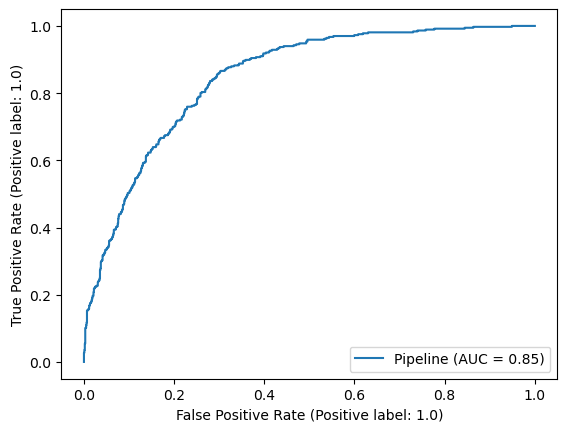

In [54]:
# On utilise la fonction autolog qui permet de tracker tous les paramètres des modèles
mlflow.sklearn.autolog()

with mlflow.start_run(experiment_id = 1):
    model = lr_model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    accuracy, f1, recall, precision, auc = eval_metrics(y_test, y_pred)
    print("  accuracy: %s" % accuracy)
    print("  f1: %s" % f1)
    print("  recall: %s" % recall) 
    print("  precision: %s" % precision) 
    print("  auc: %s" % auc) 

    mlflow.log_param("Variables", X_test.columns) # Enregistre un paramètre du modéle
    # mlflow.log_param("class_weight",{0:1,1:1.5}) # Enregistre un paramètre du modéle
    # mlflow.log_param("max_iter",250) # Enregistre un paramètre du modéle
    # mlflow.log_metric("precision", precision) # Enregistre une métrique
    # mlflow.log_metric("f1", f1)
    # mlflow.log_metric("recall", recall)
    # mlflow.log_metric("precision", precision)
    # mlflow.log_metric("auc", auc)                 

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(lr, "model", registered_model_name="simple_logisticreggression")
    else:
        mlflow.sklearn.log_model(lr, "model") 
        
plot_roc_curve(model, X_test, y_test)

# Première regression avec Stat models

In [55]:
import statsmodels.api as sm
import mlflow.statsmodels

In [56]:
mlflow.statsmodels.autolog()

with mlflow.start_run(experiment_id = 1):
    # Logistic regression model
    log_reg = sm.Logit(y_train, X_train).fit(maxiter=100,method='powell')
    yhat = log_reg.predict(X_test)
    y_pred = list(map(round, yhat))


    accuracy, f1, recall, precision, auc = eval_metrics(y_test, y_pred)
    print("  accuracy: %s" % accuracy)
    print("  f1: %s" % f1)
    print("  recall: %s" % recall) 
    print("  precision: %s" % precision) 
    print("  auc: %s" % auc) 

    mlflow.log_param("Variables", X_test.columns)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("auc", auc) 
    

C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\scipy\optimize\optimize.py:2216: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 0.419500
         Iterations: 9
         Function evaluations: 2144
  accuracy: 0.7924662402274343
  f1: 0.5680473372781066
  recall: 0.5245901639344263
  precision: 0.6193548387096774
  auc: 0.7056188091526118


# Consignes

Essayer plusieurs regressions logistiques en faisant varier les variables en input (pensez à tester une discrétisation des varibles continues) et les paramètres afin d'optimiser la métrique prise pour cible.